# LSTM Baseline Model Testing

## Imports and static variables

In [70]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [71]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc
from sklearn.ensemble import RandomForestClassifier

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [72]:
DATA_FOLDER = Path("../data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [73]:
MODEL = 'lstm' # 'lstm', 'xgb', 'random_forest
MOVING_AVERAGES = [40, 20, 10]
MA_FEATURES = [f'{ma}d MA' for ma in MOVING_AVERAGES]
FEATURES = ['Trend', 'Log Open', 'Log High', 'Log Low', 'Log Close', 'Volume', 'Daily Returns Percent', 'Intra Day Returns Percent'] + MA_FEATURES
CLASSES = ['down', 'up']

LEARNING_RATE = 0.0001 if MODEL == 'lstm' else 0.0001
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

SEQ_LEN = 7
BATCH_SIZE = 8
HIDDEN_SIZE = 4
NUM_LAYERS = 1
OUTPUT_LOGITS = True
BIDIRECTIONAL = True

NUM_EPOCHS = 1000

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [75]:
aapl = load_complete_time_series(REAL_DATA_FOLDER / "AAPL_complete.csv")

In [76]:
aapl

,Close,Open,High,Low,Adj Close,Volume,Date
0,0.128348,0.128348,0.128906,0.128348,0.099058,469033600,1980-12-12
1,0.121652,0.122210,0.122210,0.121652,0.093890,175884800,1980-12-15
2,0.112723,0.113281,0.113281,0.112723,0.086999,105728000,1980-12-16
3,0.115513,0.115513,0.116071,0.115513,0.089152,86441600,1980-12-17
4,0.118862,0.118862,0.119420,0.118862,0.091737,73449600,1980-12-18
...,...,...,...,...,...,...,...
10973,209.070007,209.149994,211.380005,208.610001,209.070007,56713900,2024-06-25
10974,213.250000,211.500000,214.860001,210.639999,213.250000,66213200,2024-06-26
10975,214.100006,214.690002,215.740005,212.350006,214.100006,49772700,2024-06-27
10976,210.619995,215.770004,216.070007,210.300003,210.619995,82542700,2024-06-28


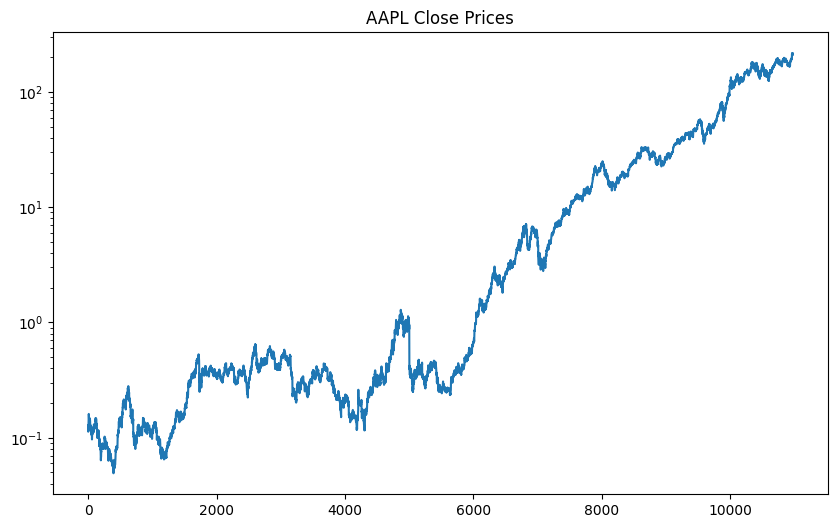

In [77]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'])
plt.yscale('log')
plt.title('AAPL Close Prices')
plt.show()

## Feature Engineering

In [78]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
aapl['Daily Returns Percent'] = aapl['Close'].pct_change()

In [79]:
aapl['Intra Day Returns Percent'] = ((aapl['Close'] - aapl['Open']) / aapl['Open']) * 100

In [80]:
# get log values
aapl['Log Close'] = np.log(aapl['Close'])
aapl['Log Open'] = np.log(aapl['Open'])
aapl['Log High'] = np.log(aapl['High'])
aapl['Log Low'] = np.log(aapl['Low'])

In [81]:
# Create moving averages
for ma in MOVING_AVERAGES:
    aapl[f'{ma}d MA'] = aapl['Close'].rolling(window=ma).mean()

In [82]:
# set trend to 1 if daily return > 1, else -1
aapl['Trend'] = aapl['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [83]:
aapl = aapl.dropna()
aapl = aapl[FEATURES]

In [84]:
aapl.head(25)

,Trend,Log Open,Log High,Log Low,Log Close,Volume,Daily Returns Percent,Intra Day Returns Percent,40d MA,20d MA,10d MA
39,0,-2.097459,-2.097459,-2.106591,-2.106591,16755200,-0.052171,-0.909032,0.137054,0.135519,0.128851
40,0,-2.106591,-2.102014,-2.106591,-2.106591,18345600,0.000000,0.000000,0.136886,0.134794,0.126730
41,0,-2.134498,-2.134498,-2.139226,-2.139226,13843200,-0.032108,-0.471666,0.136789,0.133845,0.124665
42,0,-2.143976,-2.143976,-2.148757,-2.148757,14560000,-0.009487,-0.477011,0.136886,0.132701,0.122991
43,0,-2.163215,-2.163215,-2.172970,-2.172970,11155200,-0.023922,-0.970815,0.136844,0.131473,0.121763
44,1,-2.148757,-2.143976,-2.148757,-2.148757,12275200,0.024508,0.000000,0.136788,0.129966,0.121540
45,1,-2.106591,-2.097459,-2.106591,-2.106591,19241600,0.043068,0.000000,0.136677,0.128934,0.121373
46,0,-2.163215,-2.163215,-2.168080,-2.168080,22310400,-0.059637,-0.485407,0.136230,0.127399,0.120033
47,0,-2.218088,-2.218088,-2.223229,-2.223229,24371200,-0.053655,-0.512788,0.135491,0.125474,0.118080
48,1,-2.207884,-2.202821,-2.207884,-2.207884,14112000,0.015463,0.000000,0.134612,0.123661,0.116239


In [85]:
aapl_np = aapl.to_numpy()

In [86]:
aapl_train, aapl_test = train_test_split(aapl_np, FIRST_SPLIT)
aapl_test, aapl_val = train_test_split(aapl_test, SECOND_SPLIT)

In [87]:
# account for moving averages
aapl_test = aapl_test[max(MOVING_AVERAGES):]
aapl_val = aapl_val[max(MOVING_AVERAGES):]

In [88]:
aapl_val.shape

(1054, 11)

In [89]:
aapl_test_dummy = split_data_into_sequences(aapl_test, SEQ_LEN)

Shape of the data after splitting into sequences: (1048, 7, 11)


In [90]:
scaler = Scaler(aapl_train, scale_features_individually=False)

In [91]:
aapl_train_scaled = scaler.scale_data(aapl_train)
aapl_test_scaled = scaler.scale_data(aapl_test)
aapl_val_scaled = scaler.scale_data(aapl_val)

In [92]:
aapl_train_seq_scaled = split_data_into_sequences(aapl_train_scaled, SEQ_LEN)
aapl_test_seq_scaled = split_data_into_sequences(aapl_test_scaled, SEQ_LEN)
aapl_val_seq_scaled = split_data_into_sequences(aapl_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (8745, 7, 11)
Shape of the data after splitting into sequences: (1048, 7, 11)
Shape of the data after splitting into sequences: (1048, 7, 11)


In [93]:
aapl_train_seq_scaled[0]

array([[ 0.        , -0.59672129, -0.59662035, -0.60327031, -0.6011866 ,
         0.00225761, -0.1005812 , -0.03732826,  0.00425706,  0.00417461,
         0.00393885],
       [ 0.        , -0.59931928, -0.59791616, -0.60327031, -0.6011866 ,
         0.00247191,  0.        ,  0.        ,  0.00425186,  0.00415227,
         0.00387402],
       [ 0.        , -0.60725873, -0.60715601, -0.61261601, -0.61050002,
         0.00186525, -0.06190183, -0.01936839,  0.00424882,  0.00412304,
         0.00381091],
       [ 0.        , -0.60995522, -0.60985204, -0.61534566, -0.61322024,
         0.00196183, -0.01828932, -0.01958788,  0.00425186,  0.0040878 ,
         0.00375973],
       [ 0.        , -0.61542859, -0.61532448, -0.62227955, -0.62013018,
         0.00150306, -0.04611988, -0.0398653 ,  0.00425056,  0.00404999,
         0.0037222 ],
       [ 1.        , -0.61131555, -0.60985204, -0.61534566, -0.61322024,
         0.00165397,  0.0472502 ,  0.        ,  0.00424882,  0.00400357,
         0.003

In [94]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(aapl_train_seq_scaled, aapl_test_seq_scaled, aapl_val_seq_scaled)

In [95]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [96]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [97]:
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()
criterion_binary_logits = nn.BCEWithLogitsLoss()
criterion_binary = nn.BCELoss()

In [98]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []
validation_loss_accumulation_callback = ValidationLossAccumulationCallback(val_losses)

In [99]:
if MODEL == 'lstm':

    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=X_train.shape[2], # number of features
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion_binary_logits if OUTPUT_LOGITS else criterion_binary,
                        optimizer=optimizer,
                        device=device,
                        verbose=True)
        
elif MODEL == 'xgb':

    model = XGBClassifier(
        objective='binary:logistic',      
        max_depth=10,       
        learning_rate=0.00005,
        n_estimators=1000,
        verbosity=2,
        early_stopping_rounds=10,
        callbacks=[validation_loss_accumulation_callback], 
        reg_alpha=0.01,
        reg_lambda=0.01
    )
    
    model.fit(
        X_train.reshape((X_train.shape[0], -1)), 
        y_train,
        eval_set=[(X_val.reshape((X_val.shape[0], -1)), y_val)]
    )

elif MODEL == 'random_forest':
    model = RandomForestClassifier(
        n_estimators=1000,  # Anzahl der Bäume
        max_depth=10,       # Maximale Tiefe der Bäume
        random_state=42,    # Zufallsstartwert für Reproduzierbarkeit
        verbose=1           # Verbose-Level für Ausgabe
    )

    model.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

Epoch: 1
Training Loss: 0.6984281176328659
Training Loss: 0.6940477055311203
Training Loss: 0.6938291907310485
Training Loss: 0.6935023263096809
Training Loss: 0.6939750006794929
Validation Loss: 0.691547469328378
Validation Accuracy: 52.67175572519084
**************************************************
Epoch: 2
Training Loss: 0.6961053439974785
Training Loss: 0.692918356359005
Training Loss: 0.6928074637055397
Training Loss: 0.6933929750323296
Training Loss: 0.6935645550489425
Validation Loss: 0.6914969323245623
Validation Accuracy: 52.67175572519084
**************************************************
Epoch: 3
Training Loss: 0.694781270623207
Training Loss: 0.6923574259877205
Training Loss: 0.6922988638281822
Training Loss: 0.6933977174758911
Training Loss: 0.6931585061550141
Validation Loss: 0.6914878173638846
Validation Accuracy: 52.67175572519084
**************************************************
Epoch: 4
Training Loss: 0.6940786963701249
Training Loss: 0.6920726791024208
Training Lo

Text(0.5, 1.0, 'Validation Accuracy')

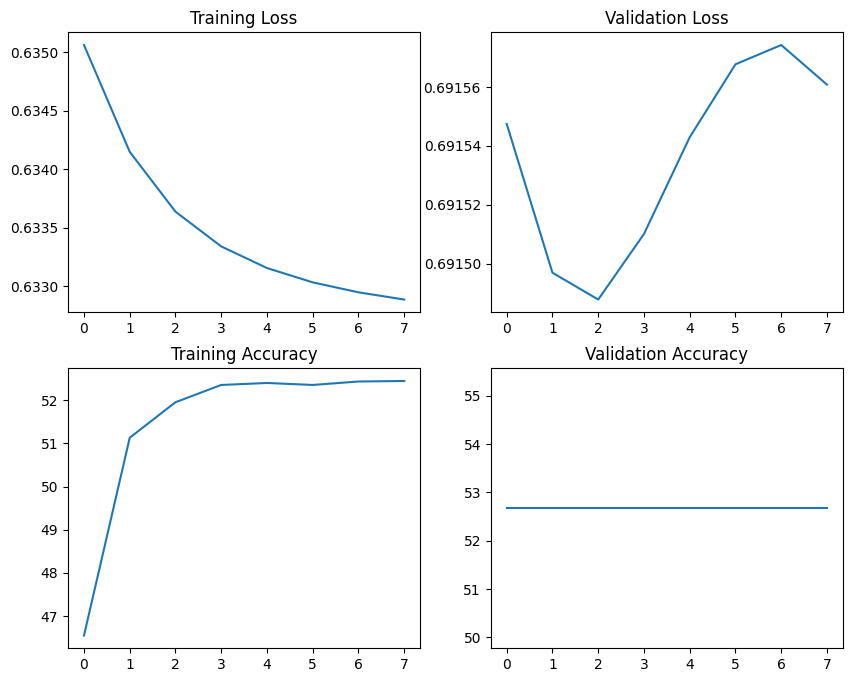

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

## Evaluation

In [101]:
if MODEL == 'lstm':

    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

elif MODEL == 'xgb':
        
    test_preds = model.predict(X_test.reshape((X_test.shape[0], -1)))

elif MODEL == 'random_forest':
        
    test_preds = model.predict(X_test.reshape((X_test.shape[0], -1)))

In [102]:
test_preds.max()

tensor(1.)

In [103]:
100 / len(y_test) * np.count_nonzero(y_test == 0)

45.99236641221374

In [104]:
# calculate accuracy and loss for test set
test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds).reshape(-1, 1))
test_loss = criterion_binary(torch.tensor(test_preds, dtype=torch.float32).reshape(-1, 1), y_test).item()

# calculate accuracy and loss for predicting always zeros
zeros_acc = accuracy(y_true=y_test, y_pred=torch.zeros_like(torch.tensor(y_test)))
zeros_loss = criterion_binary(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()

print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')
print(f'Zero Accuracy: {zeros_acc}')
print(f'Zero Loss: {zeros_loss}')

Test Accuracy: 54.007633587786266
Test Loss: 45.992366790771484
Zero Accuracy: 45.99236641221374
Zero Loss: 54.007633209228516


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/3958726577.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds).reshape(-1, 1))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/3958726577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = criterion_binary(torch.tensor(test_preds, dtype=torch.float32).reshape(-1, 1), y_test).item()
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/3958726577.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

In [105]:
torch.randn(3, 2)

tensor([[ 0.9035,  0.7144],
        [-1.3224, -0.2801],
        [ 0.4168, -1.9139]])

### dummy testing

In [106]:
dummy = MeanRegressor()

In [107]:
dummy_preds = dummy.make_predictions(aapl_test_dummy, returns=True if 'Daily Returns' in FEATURES else False)

In [108]:
loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
loss

# plot train data
plt.title(f'Dummy Model Test Data Predictions ({test_range[1]-test_range[0]} Days)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(dummy_preds[test_range[0]: test_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/2832236691.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1048, 1])) that is different to the input size (torch.Size([1048])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


NameError: name 'test_range' is not defined